# Tarea 4 - Redes Neuronales

### Grupo 8:
     - Matías González 5199522-2
     - Leonardo Melgar 5206567-4
     - Emiliano Silva 5127389-8


# 1. Objetivo

Este laboratorio tiene por objetivos:

a) la construcción, utilizando bibliotecas de código abierto, de algoritmos basados en redes neuronales para ser aplicadas sobre un problema de clasificación

b) la evaluación de los modelos construidos


# 2. Diseño

## 2.1 Preparación y División de Conjuntos de Datos para Entrenamiento, Validación y Test

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lab4 import *

In [3]:
# 1. Cargar el dataset
dataset = pd.read_csv("./lab1_dataset.csv")
preprocessed_dataset = dataset.drop(["cid", "pidnum", "time"], axis=1)
target_column = dataset["cid"]

# Dividir en 80% entrenamiento y 20% test
dataset_train_full, dataset_test, target_train_full, target_test = train_test_split(
    preprocessed_dataset,
    target_column,
    test_size=0.2,
    random_state=42,
    stratify=target_column,
)

# Separar 10% del conjunto de entrenamiento completo para validación
dataset_train, dataset_val, target_train, target_val = train_test_split(
    dataset_train_full,
    target_train_full,
    test_size=0.1,
    random_state=42,
    stratify=target_train_full,
)

Usamos stratify=target_column para asegurar que la proporción de clases en los conjuntos de entrenamiento y prueba sea representativa de la del conjunto de datos original. Esto ocasiona que la distribución de las clases en el conjunto de entrenamiento sea equivalente a la del conjunto completo, lo cual es fundamental en problemas con desbalance de clases.


El conjunto de validación permite ajustar los hiperparámetros sin emplear el conjunto de testeo final, evitando posibles problemas de sobreajuste.


In [3]:
# Mostrar los tamaños de los conjuntos
print(f"Tamaño del conjunto de datos completo: {preprocessed_dataset.shape[0]}")
print(f"Tamaño del conjunto de entrenamiento completo: {dataset_train_full.shape[0]}")
print(f"Tamaño del conjunto de entrenamiento: {dataset_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {dataset_val.shape[0]}")
print(f"Tamaño del conjunto de test: {dataset_test.shape[0]}")

Tamaño del conjunto de datos completo: 2139
Tamaño del conjunto de entrenamiento completo: 1711
Tamaño del conjunto de entrenamiento: 1539
Tamaño del conjunto de validación: 172
Tamaño del conjunto de test: 428


## 2.2 Modelo de Regresión Logística

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador y transformar los conjuntos de entrenamiento y validación
dataset_train_scaled = scaler.fit_transform(dataset_train)
dataset_val_scaled = scaler.transform(dataset_val)

# Inicializar el modelo de regresión logística
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
logistic_model.fit(dataset_train_scaled, target_train)

# Realizar predicciones en el conjunto de validación
target_pred_val = logistic_model.predict(dataset_val_scaled)

# Calcular la accuracy en el conjunto de validación
accuracy_val = accuracy_score(target_val, target_pred_val)
print(f"Accuracy en el conjunto de validación: {accuracy_val:.4f}")

Accuracy en el conjunto de validación: 0.8488


### `LogisticRegression`

- Estima la probabilidad de que una observación pertenezca a una clase específica utilizando una función logística, adecuada para clasificación binaria.

- Asume una relación lineal entre las características y el logaritmo de las probabilidades.

- Los coeficientes son fácilmente interpretables en términos de su efecto en la probabilidad de la clase.

- El uso de `StandardScaler` es crucial para asegurar que todas las características tengan igual peso en el modelo.

### Escalado de Datos

Se aplicó `StandardScaler` para estandarizar los datos, transformando las características para que tengan una media de 0 y una desviación estándar de 1.
Se ajustó el escalador `fit_transform` en el conjunto de entrenamiento y luego se aplicó `transform` en el conjunto de validación.

La estandarización de los datos es una práctica común en modelos como regresión logística para asegurar que todas las características tengan la misma escala, lo cual facilita la convergencia y mejora la estabilidad numérica.

Importante no olvidar también escalar el conjunto de test con el mismo escalador `scaler` cuando se haga la evaluación final!

### Entrenamiento del Modelo

Se utilizó `max_iter=1000` para permitir más iteraciones y evitar problemas de convergencia.

Se entrenó el modelo usando el conjunto de datos de entrenamiento escalado `dataset_train_scaled` y sus clases objetivo correspondientes `target_train`.

### Evaluación del Modelo en el Conjunto de Validación

Se utilizó el modelo entrenado para hacer predicciones en el conjunto de validación.

La `accuracy` se calculó comparando las predicciones con las clases verdaderas del conjunto de validación `target_val`, obteniendo un valor de `0.8488`. Este resultado ofrece una estimación de la capacidad del modelo para generalizar a datos no vistos.

## 2.3 Red neuronal de una neurona lineal

Sin función de activación, con dos salidas, una para cada clase objetivo posible del conjunto de datos

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Convertir los datos a tensores
dataset_train_tensor = torch.FloatTensor(dataset_train_scaled)
target_train_tensor = torch.LongTensor(target_train.values)  # Asegúrate de que 'target_train' sea un arreglo de enteros
dataset_val_tensor = torch.FloatTensor(dataset_val_scaled)
target_val_tensor = torch.LongTensor(target_val.values)

# Definir el modelo
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(dataset_train_tensor.shape[1], 2)  # Asumiendo 2 clases

    def forward(self, x):
        return self.linear(x)

# Inicializar el modelo, la función de pérdida y el optimizador
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Variables para almacenar la pérdida y precisión
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Entrenamiento del modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    optimizer.zero_grad()
    outputs = model(dataset_train_tensor)
    loss = criterion(outputs, target_train_tensor)
    loss.backward()
    optimizer.step()

    # Calcular precisión de entrenamiento
    _, predicted_train = torch.max(outputs.data, 1)
    train_accuracy = (predicted_train == target_train_tensor).sum().item() / len(target_train_tensor)

    # Validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(dataset_val_tensor)
        val_loss = criterion(val_outputs, target_val_tensor)

        # Calcular precisión de validación
        _, predicted_val = torch.max(val_outputs.data, 1)
        val_accuracy = (predicted_val == target_val_tensor).sum().item() / len(target_val_tensor)

    # Guardar estadísticas
    train_loss_history.append(loss.item())
    val_loss_history.append(val_loss.item())
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)

    # Imprimir información de cada época
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [10/100], Train Loss: 0.6454, Train Accuracy: 0.6407, Val Loss: 0.6068, Val Accuracy: 0.6977
Epoch [20/100], Train Loss: 0.6291, Train Accuracy: 0.6608, Val Loss: 0.5898, Val Accuracy: 0.7035
Epoch [30/100], Train Loss: 0.6150, Train Accuracy: 0.6842, Val Loss: 0.5752, Val Accuracy: 0.7209
Epoch [40/100], Train Loss: 0.6027, Train Accuracy: 0.6959, Val Loss: 0.5626, Val Accuracy: 0.7616
Epoch [50/100], Train Loss: 0.5919, Train Accuracy: 0.7102, Val Loss: 0.5516, Val Accuracy: 0.7849
Epoch [60/100], Train Loss: 0.5824, Train Accuracy: 0.7212, Val Loss: 0.5419, Val Accuracy: 0.7907
Epoch [70/100], Train Loss: 0.5740, Train Accuracy: 0.7264, Val Loss: 0.5333, Val Accuracy: 0.7849
Epoch [80/100], Train Loss: 0.5665, Train Accuracy: 0.7388, Val Loss: 0.5257, Val Accuracy: 0.7965
Epoch [90/100], Train Loss: 0.5597, Train Accuracy: 0.7420, Val Loss: 0.5189, Val Accuracy: 0.8140
Epoch [100/100], Train Loss: 0.5536, Train Accuracy: 0.7453, Val Loss: 0.5127, Val Accuracy: 0.8140


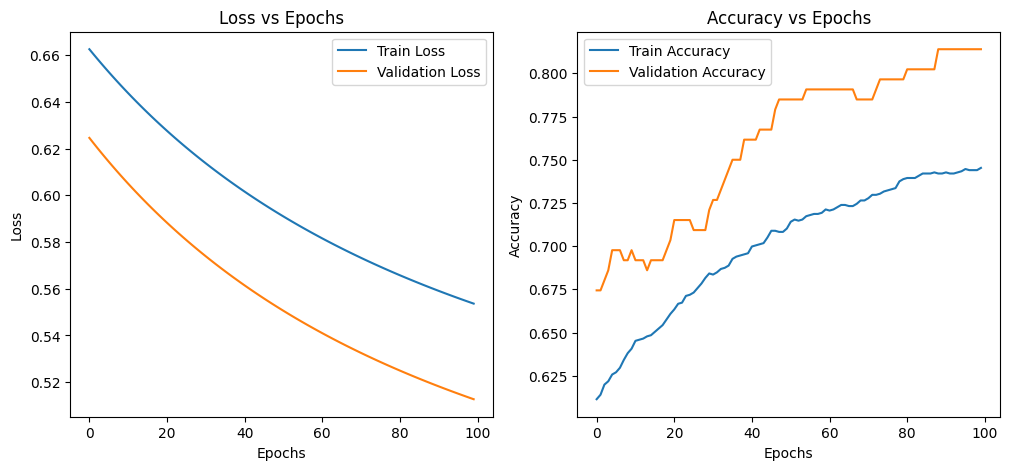

In [8]:
## 3.6. Graficar la pérdida y la precisión
plt.figure(figsize=(12, 5))

## Gráfica de la pérdida
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Gráfica de la precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## X.X Experimentando con diferentes arquitecturas

A partir de los resultados anteriores, en esta sección propondremos tres arquitecturas adicionales que busquen mejorar los resultados, modificando la cantidad de unidades, la cantidad de capas ocultas, y/o diferentes funciones de activación. Para cada una, evaluaremos
sus rendimientos sobre el conjunto de validación, con diferentes valores de tasa de aprendizaje. Llamaremos Modelo 5 al modelo con mejores
resultados sobre el conjunto de validación.

### Arquitectura 1 (sin función de activación, capa oculta de 16 unidades, 1 salida)
La Arquitectura 1 fue diseñada para observar el efecto de una capa oculta en una red sin función de activación en la salida. Este modelo buscaba analizar si agregar una capa oculta con 16 unidades permitiría captar relaciones no tan directas en los datos. Sin embargo, la precisión obtenida fue baja (alrededor de 36%), lo que indica que, pese a contar con una capa oculta, la ausencia de una función de activación en la salida y el tener una sola salida limita su capacidad de interpretación.

Además, se experimentó con tasas de aprendizaje diferentes. El rendimiento varió, alcanzando una precisión máxima de 45.48% en entrenamiento y 45.93% en validación con una tasa de aprendizaje de 0.001, pero decayó con una tasa de 0.1, mostrando que esta arquitectura es sensible a la elección de tasa de aprendizaje, aunque en general no alcanza buenos resultados.


In [ ]:
learning_rates = [0.001, 0.01, 0.1]

# Modelo 5.1
input_size = dataset_train_scaled.shape[1]
hidden_layers = [16]
output_size = 1
activation_fn = None
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.01)
num_epochs = 100

for lr in learning_rates:
    print("-------------------------------------------------------------------------------------------")
    print(f"Entrenando modelo 5.1 con tasa de aprendizaje: {lr}")
    optimizer_fn = lambda params: torch.optim.Adam(params, lr=lr)
    trained_model51 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)

del optimizer_fn, loss_fn

### Arquitectura 2 (2 salidas, sin función de activación, 2 capas ocultas de 16 unidades cada una)

La Arquitectura 2 se diseñó basada en el buen desempeño del Modelo 2, el cual demostró que tener una salida específica para cada clase mejora la precisión (83.14% en este modelo). Para esta arquitectura, se agregaron dos capas ocultas de 16 unidades cada una, incrementando la capacidad de representación del modelo.

Las pruebas con diferentes tasas de aprendizaje mostraron que la arquitectura es bastante robusta a estos cambios, alcanzando una precisión de hasta 84.30% con una tasa de aprendizaje de 0.1. Creemos que la mejora respecto a la Arquitectura 1 se debe más a tener dos salidas que al incremento de capas ocultas.


In [ ]:
input_size = dataset_train_scaled.shape[1]
hidden_layers = [16, 16]
output_size = 2
activation_fn = None
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)
num_epochs = 100

for lr in learning_rates:
    print("-------------------------------------------------------------------------------------------")
    print(f"Entrenando modelo 5.2 con tasa de aprendizaje: {lr}")
    optimizer_fn = lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9)
    trained_model52 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)

del optimizer_fn, loss_fn

### Arquitectura 3 (función de activación sigmoide, sin capas ocultas, 2 salidas)

Para la Arquitectura 3, se utilizó una sola capa con dos salidas y una función de activación sigmoide, lo cual fue efectivo para lograr una precisión máxima de 83%. Se mantuvo la idea de utilizar dos salidas independientes para cada clase, optimizando así el aprendizaje de probabilidades para cada una.

Al variar las tasas de aprendizaje, el modelo mostró que responde favorablemente a estas modificaciones, alcanzando una precisión de validación de 84.88% con una tasa de 0.1. Esto sugiere que tener dos salidas y una activación sigmoide es una configuración poderosa y flexible en términos de aprendizaje.


In [ ]:
input_size = dataset_train_scaled.shape[1]
hidden_layers = []
output_size = 2
activation_fn = nn.Sigmoid()
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)
num_epochs = 100

for lr in learning_rates:
    print("-------------------------------------------------------------------------------------------")
    print(f"Entrenando modelo 5.3 con tasa de aprendizaje: {lr}")
    optimizer_fn = lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9)
    trained_model53 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)

del optimizer_fn, loss_fn

del trained_model51, trained_model52, trained_model53
torch.cuda.empty_cache()

### Elección de Modelo 5

Finalmente decidimos que nuestro “Modelo 5” sería el entrenado con la arquitectura 3. Además de que demostró ser levemente mejor en casi todas las tasas de aprendizaje, lo elegimos porque creemos que el factor crucial del mejor rendimiento es tener dos salidas, dado que el modelo aprende a estimar una probabilidad independiente para cada clase. Esto le permite ajustar el valor para cada clase de forma más explícita, no dependiendo de transformar la única salida en una probabilidad para una clase y deducir la otra por complementariedad, lo que le da más flexibilidad en su proceso de aprendizaje. Además, tener una capa sola ha demostrado ser mejor en los modelos 2, 3 y 4, lo cual también aportó en la decisión. 

# 3. Experimentación

# 4. Conclusión